#### Human In the Loop
- Review for human-in-the-loop, we often want to see our graph outputs as its running.
- For this we can use Streaming.But what if as a developer or user you want a functionality that agent need your approval before or after an event like a trigger or may be you want to debug the agent while its running, in these cases we can use "Human In the Loop" Concept.
- LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

##### Example workflow : We will build something like after taking user input, before assistant deciding which tool it needs to invoke, we will interuppt the agent and do something then workflows continues to end.

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="llama-3.1-8b-instant")

In [23]:
#define tools
def multiply(a:int,b:int)->int:
    """
    Multiply a and b

    Args:
       a:first int
       b:second int
    """
    return a * b

# def add(a:int,b:int) -> int:
#     """
#     Add a and b

#     Args:
#        a:first int
#        b:second int
#     """
#     return a + b

def divide(a:int,b:int) -> float:
    """
    Divide a and b

    Args:
      a:first int
      b:second int
    """
    return a / b

tools = [divide,multiply]

In [24]:
llm_with_tools = llm.bind_tools(tools)

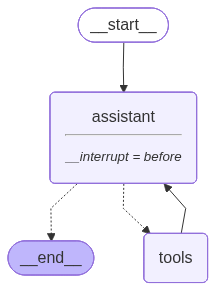

In [25]:
## workflow with LangGraph

from IPython.display import display,Image
from langgraph.graph import MessagesState,START,StateGraph
from langgraph.prebuilt import tools_condition,ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

#System Message - Instruction to the LLM
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

#Define Node
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

graph = StateGraph(MessagesState)

graph.add_node("assistant",assistant)
graph.add_node("tools",ToolNode(tools))

graph.add_edge(START,"assistant")
graph.add_conditional_edges("assistant",tools_condition)
graph.add_edge("tools","assistant")

memory = MemorySaver()

# Human In the Loop - trigger before at assistant node
graph_builder = graph.compile(interrupt_before=["assistant"],checkpointer=memory)


display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [31]:
thread = {"configurable":{"thread_id":"43"}}

initial_input = {"messages":HumanMessage(content="Multiply 2 and 3")}

In [32]:
for event in graph_builder.stream(initial_input,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


###### Explanation : Here Agent took user input and before deciding to call appropriate tool , it stops execution and waiting for human feedback, i.e, Human In the Loop.
###### Now Human Need to provide his feedback to agent to continue its execution further.

In [33]:
current_state = graph_builder.get_state(thread)
current_state.next

('assistant',)

##### It is giving 'assistant' because agent stopped execution before even going to assistant node itself.

In [41]:
## Continue the Execution
for event in graph_builder.stream(None,thread,stream_mode="values"): #Here None denotes human feedback - currently human is not giving any feedback , just continue execution of agent workflow.
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: divide

4.0
================================== Ai Message ==================================
Tool Calls:
  divide (ka2eejvsm)
 Call ID: ka2eejvsm
  Args:
    a: 8
    b: 4
================================= Tool Message =================================
Name: divide

2.0


##### Again Execution stopped here at tools node, because as per normal execution, tool msg need to go to assistant then assistant provides its AI Message.but becoz of trigger before assistant, now execution stopped again!!

In [42]:
#continue execution and then end
for event in graph_builder.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: divide

2.0
================================== Ai Message ==================================
Tool Calls:
  multiply (8p4aspjmj)
 Call ID: 8p4aspjmj
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


#### Edit the Human Feedback

In [63]:
new_thread = {"configurable":{"thread_id":"103"}}

msg = {"messages":HumanMessage(content="Multiply 12 and 2")}
for e in graph_builder.stream(msg,new_thread,stream_mode="values"):
    e["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 12 and 2


In [64]:
state = graph_builder.get_state(new_thread)
state.next

('assistant',)

In [65]:
graph_builder.update_state(new_thread,{"messages":[HumanMessage(content="No,please multiply 15 and 6")]})

{'configurable': {'thread_id': '103',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e8c98-2ab1-6cfe-8001-cc121d8b53de'}}

In [66]:
new_state = graph_builder.get_state(new_thread).values

for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 12 and 2
================================ Human Message =================================

No,please multiply 15 and 6


In [67]:
for event in graph_builder.stream(None,new_thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No,please multiply 15 and 6
================================== Ai Message ==================================

<multiply>{"a": 15, "b": 6}</multiply>


In [68]:
for event in graph_builder.stream(None,new_thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

<multiply>{"a": 15, "b": 6}</multiply>


#### Workflow will wait for user input

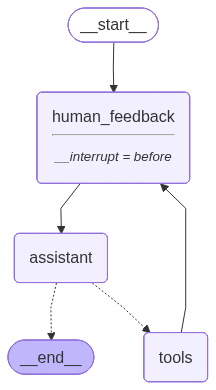

In [70]:
sys_msg = SystemMessage(content="you are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Human feedback node
def human_feedback(state:MessagesState):
    pass

def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_node("human_feedback",human_feedback)

builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools","human_feedback")

graph = builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [74]:
initial_input = {"messages":"Multiply 2 and 3"}

thread = {"configurable":{"thread_id":"987"}}

for event in graph.stream(initial_input,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

#get user input
user_input = input("Tell me how you want to update the state:")
graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

#continue graph execution
for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

please multiply 4 and 8
================================== Ai Message ==================================

<multiply>{"a": 4, "b": 8}</multiply>


In [75]:
for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

<multiply>{"a": 4, "b": 8}</multiply>
